In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

Download required NLTK data

In [153]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [4]:
def download_nltk_data():
    resources = ['punkt', 'stopwords','wordnet','omw-1.4']
    for resource in resources:
        try:
            nltk.download(resource, quiet=True)
            print(f"Successfully downloaded {resource}")
        except Exception as e:
            print(f"Failed to download {resource}: {e}")

download_nltk_data()


Successfully downloaded punkt
Successfully downloaded stopwords
Successfully downloaded wordnet
Successfully downloaded omw-1.4


Load the dataset

In [5]:
def load_data(filepath):
    """Load and return the movie reviews dataset"""
    df = pd.read_csv(r"C:\Users\USER\Downloads\IMDB Dataset.csv")
    return df

In [6]:
df = pd.read_csv(r"C:\Users\USER\Downloads\IMDB Dataset.csv")

Basic Exploration

In [7]:
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (50000, 2)

Column names: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [8]:
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


Basic statistics

In [9]:
print(f"\nTotal reviews: {len(df)}")
print(f"Average review length: {df['review'].str.len().mean():.2f} characters")
print(f"Maximum review length: {df['review'].str.len().max()} characters")
print(f"Minimum review length: {df['review'].str.len().min()} characters")


Total reviews: 50000
Average review length: 1309.43 characters
Maximum review length: 13704 characters
Minimum review length: 32 characters


Step 3: Data Visualization

Sentiment Distribution

In [10]:
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Subplot 1: Sentiment counts

(array([0, 1]), [Text(0, 0, 'positive'), Text(1, 0, 'negative')])

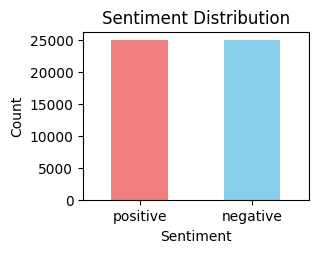

In [11]:
plt.subplot(2, 2, 1)
df['sentiment'].value_counts().plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

Subplot 2: Review length distribution

Text(0, 0.5, 'Frequency')

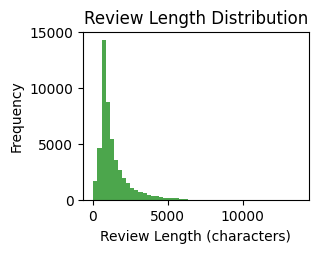

In [12]:
plt.subplot(2,2,2)
df['review_length'] = df['review'].str.len()
plt.hist(df['review_length'], bins=50, alpha=0.7 ,color='green')
plt.title('Review Length Distribution')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')

Subplot 3: Review length by sentiment

Text(0.5, 0.98, '')

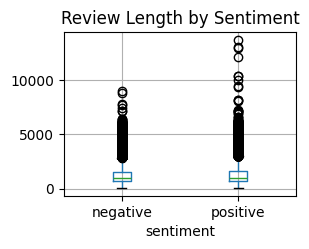

In [13]:
plt.subplot(2, 2, 3)
df.boxplot(column='review_length', by='sentiment', ax=plt.gca())
plt.title('Review Length by Sentiment')
plt.suptitle('')

Subplot 4: Word count distribution

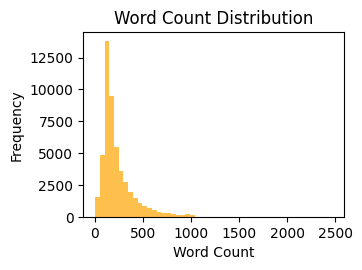

In [14]:
plt.subplot( 2, 2, 4)
df['word_count'] = df['review'].str.split().str.len()
plt.hist(df['word_count'], bins=50, alpha=0.7, color='orange')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Word clouds

In [15]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=100).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

Seperate positive and negative reviews

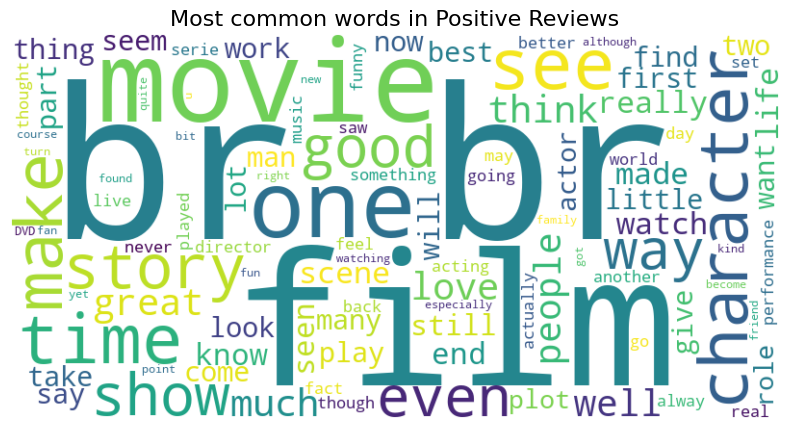

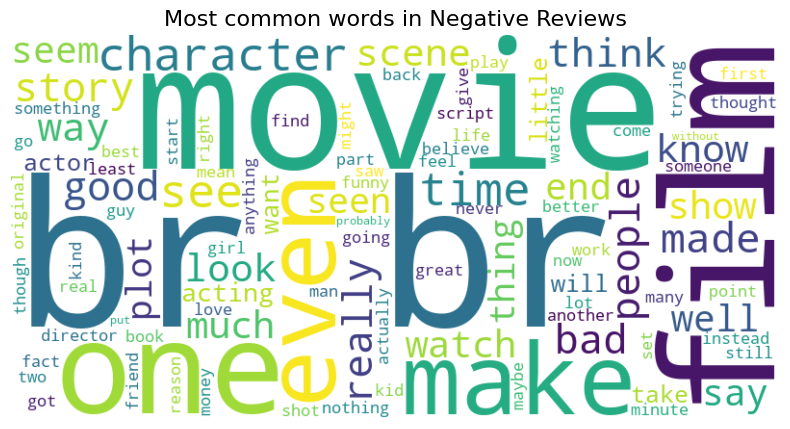

In [16]:
positive_reviews= ' '.join(df[df['sentiment'] == 'positive']['review'])
negative_reviews= ' '.join(df[df['sentiment'] == 'negative']['review'])

create_wordcloud(positive_reviews, 'Most common words in Positive Reviews')
create_wordcloud(negative_reviews, 'Most common words in Negative Reviews')

# Step 4: Text Preprocessing

In [17]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


In [18]:
def preprocess_text(text):
        """Simple preprocessing function"""
        # Convert to lowercase
        text = text.lower()
      
       # Remove HTML Tags
        text = re.sub(r'<[^>]+>', '', text)
     
       # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
   
       # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
  
       # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

       # Remove stop words
        tokens= text.split()
        tokens= [word for word in tokens if word not in ENGLISH_STOP_WORDS and len(word) > 2]
       
        return ' '.join(tokens)









    
      

In [19]:
test_result = preprocess_text("This is a great movie! I love it <br> http://example.com")
print("Function test result:", test_result)

Function test result: great movie love


In [20]:
df['cleaned_review'] = df['review'].apply(preprocess_text)
print(" Preprocessing completed!")

 Preprocessing completed!


Feature Engineering (TF-IDF Vectorization)

In [22]:
from sklearn.model_selection import  train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# Prepare data for modeling
X = df['cleaned_review']
y = df['sentiment'].map({'positive': 1, 'negative':0})

In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 40000
Test set size: 10000


In [61]:
# Create TF-IDF features:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)


In [62]:
# Fit on training data and transform both training and test data
X_train_tidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [63]:
print(f"TF-IDF feature matrix shape: {X_train_tidf.shape}")
print(" Feature engineering completed!")

TF-IDF feature matrix shape: (40000, 5000)
 Feature engineering completed!


In [64]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8
)

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_sample, _, y_sample, _ = train_test_split(
    X_train,y_train,
    train_size=0.25,
    stratify=y_train,
    random_state=42
)


In [67]:
model = LinearSVC(max_iter=1000, random_state=42)

In [68]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=1),
    'SVM':LinearSVC(max_iter=10000, random_state=42)
}

In [69]:
results ={}
print("Training and evaluating models...\n")

for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train_tidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store results - FIXED VERSION
    results[name] = {
        'model' : model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    # Fixed print statement
    print(" " + name + " - Accuracy: " + str(round(accuracy, 4)))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


print("\n  All models trained and evaluated!")


Training and evaluating models...

Training Logistic Regression...
 Logistic Regression - Accuracy: 0.8883
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

--------------------------------------------------
Training Naive Bayes...
 Naive Bayes - Accuracy: 0.8566
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      5000
           1       0.84      0.88      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

--------------------------------------------------
Training Random Forest...
 Random F

In [70]:
import matplotlib.pyplot as plt

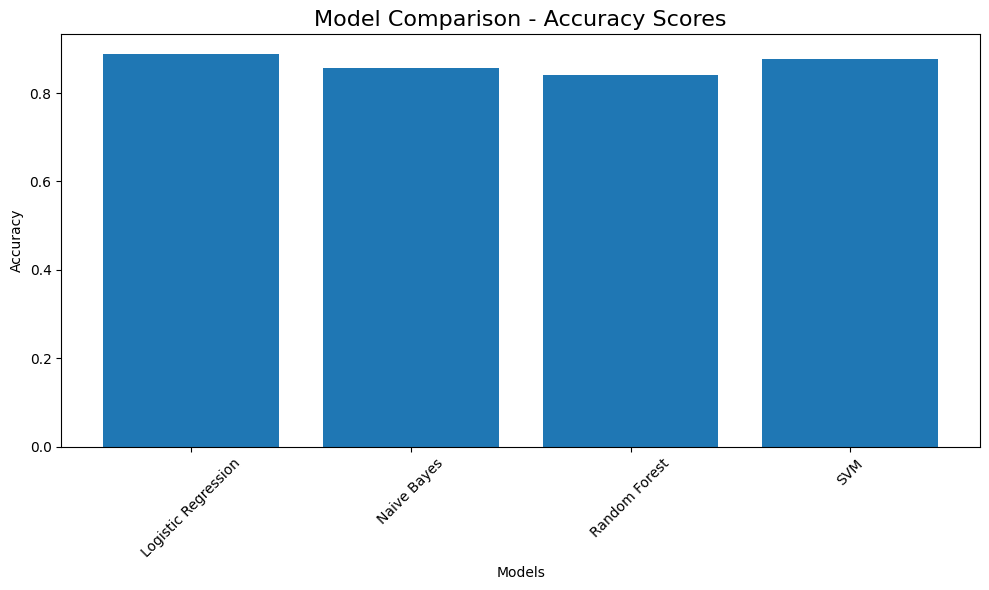


Model Accuracies:
Logistic Regression: 0.8883
Naive Bayes: 0.8566
Random Forest: 0.8406
SVM: 0.8767


In [71]:
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10,6))
bars = plt.bar(model_names, accuracies)
plt.title('Model Comparison - Accuracy Scores', fontsize=16)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print results
print("\nModel Accuracies:")
for name, acc in zip(model_names, accuracies):
    print(f"{name}: {acc:.4f}")



Visualize confusion matrix

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

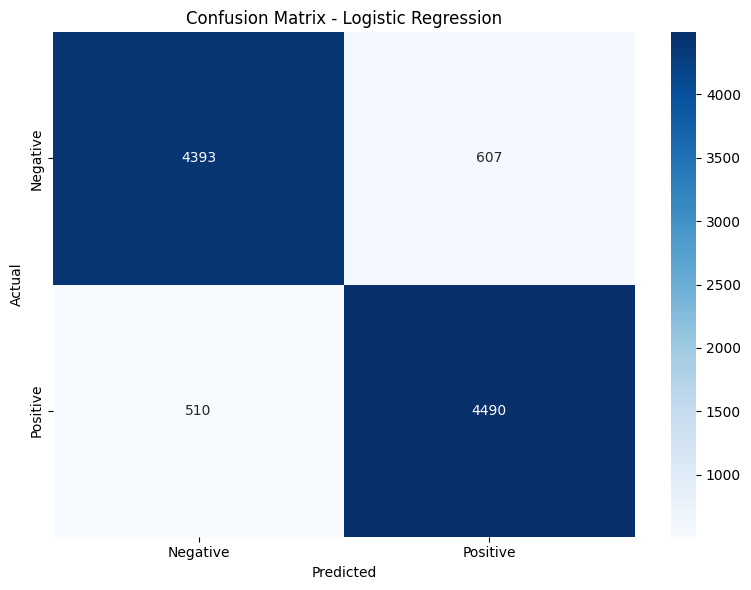


Confusion Matrix Interpretation:
True Negatives: 4393 (Correctly predicted negative reviews)
False Positives: 607 (Negative reviews predicted as positive)
False Negatives: 510 (Positive reviews predicted as negative)
True Positives: 4490 (Correctly predicted positive reviews)


In [72]:
# Create confusion matrix for the best model
best_model_name = max(results, key=lambda x: results[x] ['accuracy'])
y_pred_best = results[best_model_name]['predictions']

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Interpretation:")
print(f"True Negatives: {cm[0,0]} (Correctly predicted negative reviews)")
print(f"False Positives: {cm[0, 1]} (Negative reviews predicted as positive)")
print(f"False Negatives: {cm[1, 0]} (Positive reviews predicted as negative)")
print(f"True Positives: {cm[1, 1]} (Correctly predicted positive reviews)")



Feature Importance Analysis

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [74]:
results['Logistic Regression']['vectorizer'] = tfidf_vectorizer

In [75]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tidf = tfidf_vectorizer.fit_transform(X_train)

In [76]:
if 'Logistic Regression' in results:
    lr_model = results['Logistic Regression']['model']
    feature_names = tfidf_vectorizer.get_feature_names_out()
    coefficients = lr_model.coef_[0]

   



In [77]:
 # Get coefficients
coefficients = lr_model.coef_[0]
feature_names = list(tfidf_vectorizer.get_feature_names_out())


# Create list of (word, coefficent) pairs
word_coef_pairs = list(zip(feature_names, coefficients))

# Sort by coefficient value
word_coef_pairs.sort(key=lambda x: x[1], reverse= True)




# Top positive sentiment words
top_positive = word_coef_pairs[:15]
top_negative = word_coef_pairs[-15:][::1]

print("\nTop 15 words indicating POSITIVE sentiment:")
for word, coef in top_positive:
        print(f"  {word}: {coef:.4f}")

print("\nTop 15 words indicating NEGATIVE sentiment:")
for word, coef in top_negative:
        print(f"  {word}: {coef:.4f}")



Top 15 words indicating POSITIVE sentiment:
  emotions: 6.7882
  goodness: 6.5842
  pictures: 5.1476
  beating: 5.0926
  allowed: 4.9827
  winters: 4.7161
  help: 4.3756
  experiments: 4.3394
  lot: 4.3020
  bourne: 4.0706
  sun: 4.0186
  forms: 3.9632
  dying: 3.9619
  executed: 3.7998
  dvds: 3.6384

Top 15 words indicating NEGATIVE sentiment:
  andy: -4.4110
  demented: -4.5651
  demise: -4.6903
  events: -4.8039
  hollow: -4.9543
  displays: -5.1830
  wonderful: -5.2390
  pregnant: -5.2555
  television: -5.3427
  preferred: -5.6125
  blows: -6.1522
  attitudes: -6.9278
  walter: -7.1167
  attacks: -7.5968
  wonderfully: -9.4241


In [78]:
import matplotlib.pyplot as plt


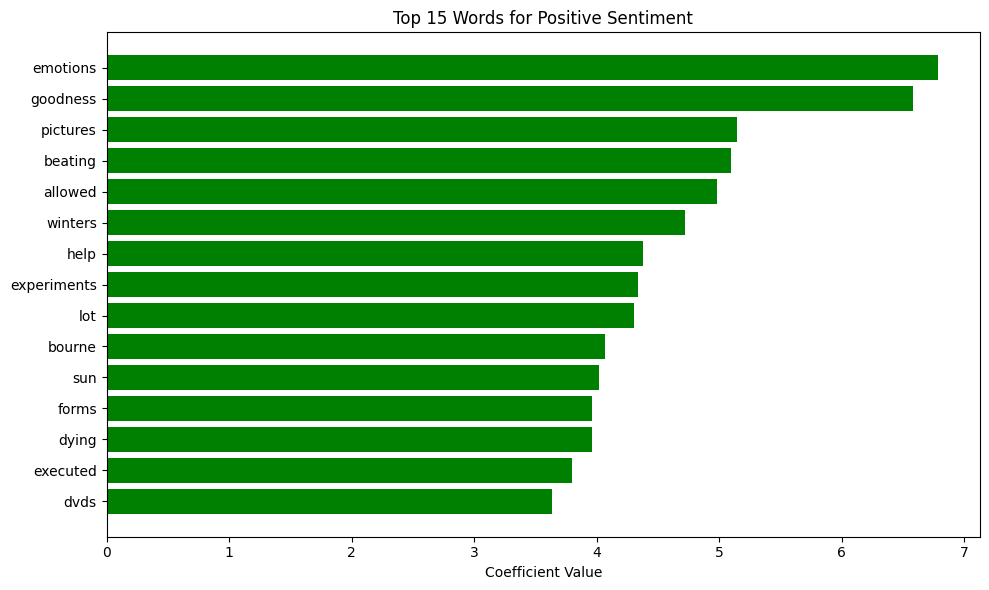

In [79]:
# Plot top positive words
words_pos = [word for word, coef in top_positive]
coefs_pos = [coef for word, coef in top_positive]

plt.figure(figsize=(10,6))
plt.barh(words_pos, coefs_pos, color='green')
plt.xlabel('Coefficient Value')
plt.title('Top 15 Words for Positive Sentiment')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [80]:
# Plot top negative words
words_neg = [word for word, coef in top_negative]
coefs_neg = [coef for word, coef in top_negative]



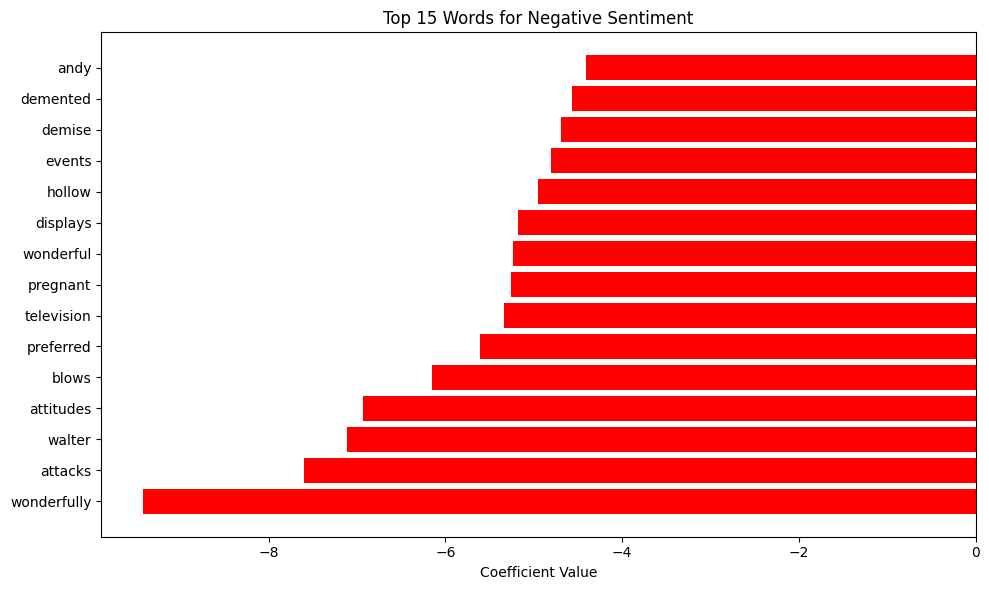

In [81]:
plt.figure(figsize=(10,6))
plt.barh(words_neg, coefs_neg, color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 15 Words for Negative Sentiment')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Analyze Model Performance in Detail

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [83]:
# Get Predictions
y_pred = lr_model.predict(X_test_tfidf)

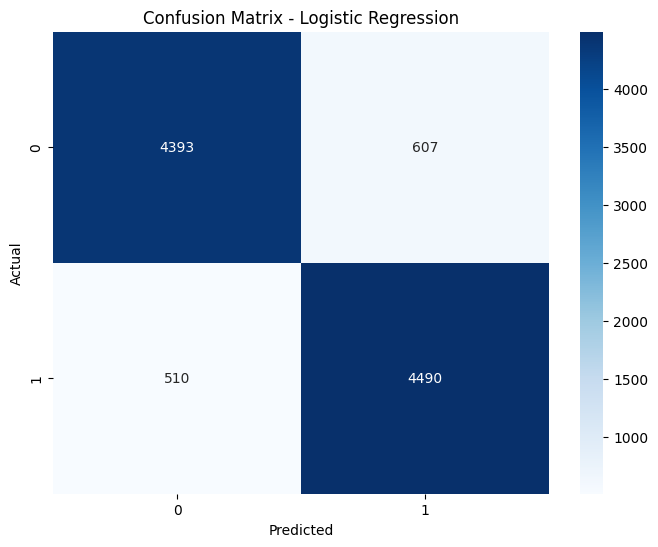


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [84]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Test on Custom Reviews

In [85]:
def predict_sentiment(review_text):
    """Predict sentiment of a custom review"""
    # Transform the text
    review_tfidf = tfidf_vectorizer.transform([review_text])

    # Get prediction and probability
    prediction = lr_model.predict(review_tfidf)[0]
    probability = lr_model.predict_proba(review_tfidf)[0]

    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = max(probability) * 100

    print(f"Review: {review_text}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Probabilities - Negative: {probability[0]:.3f}, Positive: {probability[1]:.3f}\n")

    return sentiment, confidence

# Test with custom reviews
test_reviews = [
    "This movie was absolutely amazing! Best film I've seen all year.",
    "Terrible waste of time. I want my money back.",
    "It was okay, nothing special but not bad either."
]

for review in test_reviews:
    predict_sentiment(review)
    

Review: This movie was absolutely amazing! Best film I've seen all year.
Sentiment: Positive
Confidence: 67.05%
Probabilities - Negative: 0.329, Positive: 0.671

Review: Terrible waste of time. I want my money back.
Sentiment: Negative
Confidence: 71.63%
Probabilities - Negative: 0.716, Positive: 0.284

Review: It was okay, nothing special but not bad either.
Sentiment: Positive
Confidence: 50.88%
Probabilities - Negative: 0.491, Positive: 0.509



Compara All Models

In [86]:
# Create a comparison chart
import pandas as pd

\ Model Comparison:
              Model  Accuracy Precision Recall F1-Score
Logistic Regression    0.8883       N/A    N/A      N/A
                SVM    0.8767       N/A    N/A      N/A
        Naive Bayes    0.8566       N/A    N/A      N/A
      Random Forest    0.8406       N/A    N/A      N/A


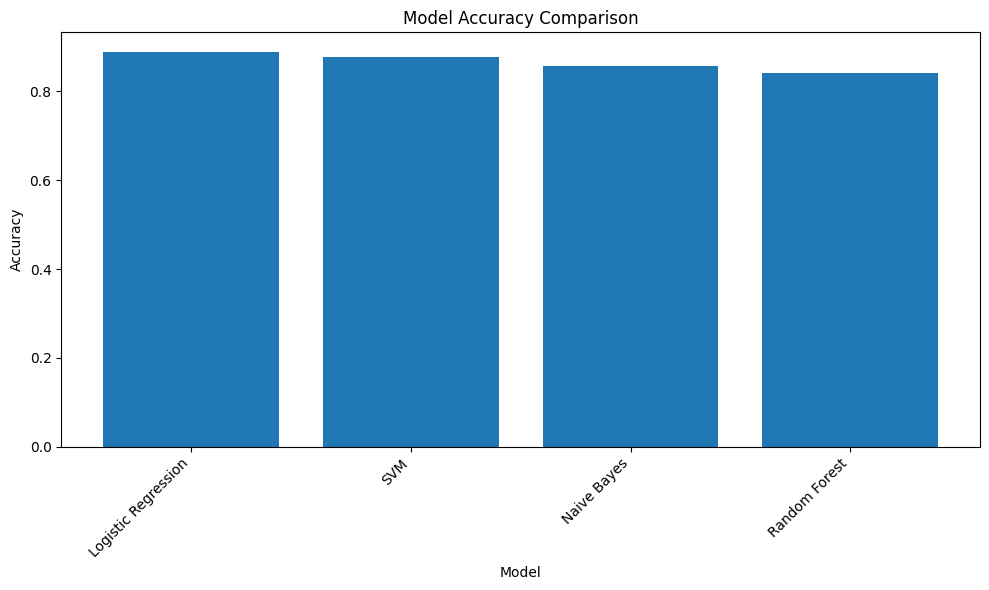

In [89]:
model_comparison = []
for model_name, model_data in results.items():
    model_comparison.append({
        'Model': model_name,
        'Accuracy': model_data['accuracy'],
        'Precision': model_data.get('precision', 'N/A'),
        'Recall': model_data.get('recall', 'N/A'),
        'F1-Score': model_data.get('f1', 'N/A')
    })


comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\ Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Model'], comparison_df['Accuracy'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Error Analysis

In [94]:
# Find misclasssified reviews
y_pred = lr_model.predict(X_test_tfidf)
misclassified_idx = np.where(y_test != y_pred)[0]

print(f"\nNumber of misclassified reviews: {len(misclassified_idx)}")
print("\nSample of misclassified reviews:")

for i in misclassified_idx[:5]:
    print(f"\nReview: {X_test.iloc[i][:200]}...")
    print(f"Actual: {'Positive' if y_test.iloc[i] == 1 else 'Negative'}")
    print(f"Predicted: {'Positive' if y_pred[i] == 1 else 'Negative'}")


Number of misclassified reviews: 1117

Sample of misclassified reviews:

Review: story bride fair amusing engaging filmmakers credit sets portray rural minnesotans respect ordinarily reserved coastdwellers weird independent movie brainchild single person unambitious clichridden co...
Actual: Negative
Predicted: Positive

Review: movie really wack really nice say moral truth expressed films climax concerning people neighborhood participating fight crime film good shots good acting good script film...
Actual: Negative
Predicted: Positive

Review: admit creating great expectations watching friends mentioned pervs just dont expect outbreakingthe freudian psychoanalyzes interesting parts film theres just perversion doesnt stick endsome good thing...
Actual: Positive
Predicted: Negative

Review: film listed having film available weird video drivers scare films vol thing version color swv disc earlier version film wlwt television channel cincinnati way film notorious unlike drivers films int

In [97]:
import joblib

Save your model

In [100]:
# Save the model and vectorizer
joblib.dump(lr_model, 'sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("Model saved successfully!")

# To load later (in a new session):
# loaded_model = joblib.load('sentiment_model.pkl')
# loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl)


Model saved successfully!
